## Evaluation Plan
1. Synthetic Data - Generate data with Noise
    i. Figure: 4 Plots - training_data, mc_dropout, concrete_dropout, mc_alpha  
    ii. Figure: (x-axis) confidence interval vs (y-axis) percentage of samples in interval   
2. Climate Downscaling Dataset (eval on test set)  
    i. Table: RMSE, Corr, Prediction intervals  
    ii. Figure: True vs Prediction, Distribution of samples for an extreme  


In [1]:
import sys
import numpy as np
import tensorflow as tf
from models import ConcreteDropout, KerasMCDropout, smooth
from keras.models import Sequential
import keras.backend as K
from keras import initializers, regularizers, optimizers
from keras.engine import InputSpec
from keras.layers import Dense, Lambda, Wrapper, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Polygon
import seaborn as sns
import scipy.stats 

sns.set_context("paper", font_scale=1.5)
np.random.seed(0)

Using TensorFlow backend.


# Set some global parameters

In [2]:
K_test = 50
batch_size = 20
n_hidden = [1024,1024,1024]
lr = 1e-4
hi_percentile = 97.5
low_percentile = 2.5
default_dropout_rate = 0.1

# Synthetic Data Generator

In [3]:
def gen_signal(X):
    return np.sin(2*X)

def gen_data(N=None, X=None, sigma=0.1):
    if X is None:
        X = np.random.randn(N,1)
    else:
        N = X.shape[0]
    noise = sigma*np.random.randn(N, 1)
    Y = gen_signal(X) + noise
    return X, Y

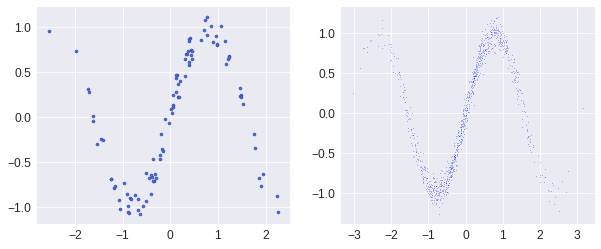

In [4]:

X, Y = gen_data(100)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X[:, 0], Y[:, 0], edgecolor='b', s=10.)

X, Y = gen_data(1000)
plt.subplot(1,2,2)
plt.scatter(X[:, 0], Y[:, 0], edgecolor='b', s=0.1)
plt.show()

# Fit Concrete Dropout

In [5]:
from keras.layers import Input, Dense, Lambda, merge
from keras.models import Model
from keras import backend as K

def fit_concrete(nb_epoch, X, Y, output_activation=None, verbose=0):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = lr**2. / N
    dd = 2. / N
    inp = Input(shape=(X.shape[1],))
    x = inp
    for h in n_hidden:
        x = ConcreteDropout(Dense(h, activation='relu'), weight_regularizer=wd, 
                            dropout_regularizer=dd)(x)
    mean = ConcreteDropout(Dense(1, activation=output_activation), 
                           weight_regularizer=wd, dropout_regularizer=dd)(x)
    log_var = ConcreteDropout(Dense(1), weight_regularizer=wd, dropout_regularizer=dd)(x)
    out = merge([mean, log_var], mode='concat')
    model = Model(inp, out)
    def heteroscedastic_loss(true, pred):
        mean = pred[:, :1]
        log_var = pred[:, 1:]
        precision = K.exp(-log_var)
        return K.sum(precision * (true - mean)**2. + log_var, -1)
    
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss=heteroscedastic_loss)
    hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    loss = hist.history['loss']
    return model, loss  # return ELBO up to const.

# MC-Dropout

In [6]:
def fit_mc(nb_epoch, X, Y, output_activation=None, verbose=0,
           alpha_divergence=True, alpha=0.5, dropout_prob=0.5):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    D = np.prod(X.shape[1:])
    inp = Input(shape=X.shape[1:])
    x = inp
    #default_dropout_rate = 0.1
    for h in n_hidden:
        x = KerasMCDropout(Dense(h, activation='relu'), dropout_prob=dropout_prob)(x)
        
    mean = KerasMCDropout(Dense(1, activation=output_activation), dropout_prob=dropout_prob)(x)
    log_var = KerasMCDropout(Dense(1), dropout_prob=default_dropout_rate)(x)
    out = merge([mean, log_var], mode='concat')
    model = Model(inp, out)
    
    def alpha_divergence_loss(true, pred):
        # heteroskedastic case
        mean = pred[:,:1]
        log_var = pred[:,1:]
        precision = K.exp(-log_var)
        ll = K.sum(precision * (true - mean)**2. + log_var, axis=0)
        l = -1/alpha*K.log(K.sum(K.exp(-alpha*ll)))

        # homoskedastic case
        #l = -1/alpha*K.log(K.sum(K.exp(-alpha*tau/2.*K.sum((true - mean)**2, axis=0))))
        #l += N * D / 2. * K.log(tau)
        return l
       # return K.sum(precision * (true - pred)**2. + log_var, -1)
    
    def heteroskedastic_loss(true, pred):
        mean = pred[:,:1]
        log_var = pred[:,1:]
        precision = K.exp(-log_var)
        return K.sum(precision * (true - mean)**2. + log_var)
        
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    if alpha_divergence:
        model.compile(optimizer=adam, loss=alpha_divergence_loss)
    else:
        model.compile(optimizer=adam, loss=heteroskedastic_loss)
        
    hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    loss = hist.history['loss']
    return model, loss  # return ELBO up to const.

# TODO: Complete this function and redo plot
def get_moments(samples):
    Y_mean = np.mean(samples[:,:,0], axis=0)
    second_moment = np.zeros(samples.shape[1])
    for k in range(samples.shape[0]):
        sample_var = np.exp(samples[k,:,1])
        sample_mean = samples[k,:,0]
        second_moment += sample_var + sample_mean**2
    Y_var = second_moment / samples.shape[0] - Y_mean**2
    return Y_mean, Y_var



## Dropout with Alpha-Divergence Loss

### General Loss function
$\mathcal{L}(\Theta) = \dfrac{1}{\alpha} \sum_n \text{log-sum-exp}\big[ -\alpha * l(y_n, f^{\hat{\omega}_k}(x_n)) \big] + L_2(\Theta)$

### Regression Loss
$l(y, f^{\hat{\omega}_k}(x_n)) = \dfrac{1}{2}||y - f^{\hat{\omega}_k}(x)||_2^2$

### Regression Alpha-Divergence Loss
$\mathcal{L}(\Theta) = -\dfrac{1}{\alpha} \sum_n \text{log-sum-exp} \big[ -\dfrac{\alpha\tau}{2}||y - f^{\hat{\omega}_k}(x)||_2^2 \big] + \dfrac{ND}{2}\text{log}\tau + \sum_i p_i ||M_i||_2^2$

## Experiments with Synthetic Data

### Figure 1

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


KeyboardInterrupt: 

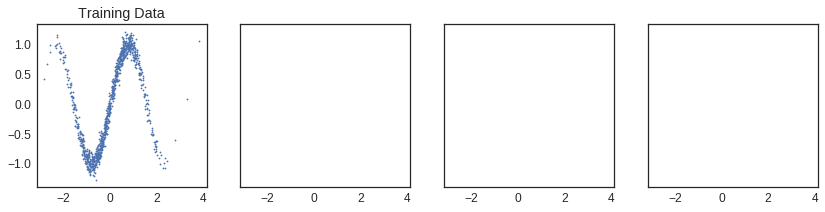

In [7]:
sns.set_style("white")
N = 1000
Kmc = 50
sigma = 0.1
epochs = 100
X_train, Y_train = gen_data(N=N, sigma=sigma)

X_test = np.arange(-2.5, 2.5, 0.01)
Y_signal = gen_signal(X_test[:,np.newaxis])
_, Y_test = gen_data(X=X_test[:,np.newaxis], sigma=sigma)

fig, axs = plt.subplots(1,4, figsize=(14,3), sharex=True, sharey=True)
axs = np.ravel(axs)
axs[0].scatter(X_train, Y_train, s=2)
axs[0].set_title("Training Data")


test_results=dict()
plot_labels = ['A)', 'B)', 'C)', 'D)']
for j in range(3):
    if j == 0:
        name = 'MC Dropout'
        model, _ = fit_mc(epochs, X_train, Y_train, verbose=0, alpha_divergence=False, 
                        dropout_prob=default_dropout_rate)
    elif j == 1:
        name = 'Alpha-Divergence'
        model, _ = fit_mc(epochs, X_train, Y_train, verbose=0, alpha_divergence=True, 
                        dropout_prob=default_dropout_rate)
    elif j == 2:
        name = 'Concrete Dropout'
        model, _ = fit_concrete(epochs, X_train, Y_train, verbose=0)
    
    print name
    
    Y_samples = np.array([model.predict(X_test[:,np.newaxis]) for _ in range(Kmc)])
    plt.hist(Y_samples[:,:,1].flatten())
    plt.title(name)
    plt.show()
    
    Y_mean, Y_var = get_moments(Y_samples)
    Y_std = np.sqrt(Y_var)
    print np.mean(Y_std), np.std(Y_std)
    test_results[name] = dict(mu=Y_mean, std=Y_std, samples=Y_samples)
    
    window_len = 41
    pad = window_len - 1
    Y_mean_smooth = smooth(Y_mean, window_len)[pad:-pad]
    for i, z in enumerate([3., 2., 1.]):        
        yhi = smooth(Y_mean + z*Y_std, window_len)[pad:-pad]
        ylow = smooth(Y_mean - z*Y_std, window_len)[pad:-pad]
        hi_percentile = scipy.stats.norm.cdf(z)*100.
        low_percentile = 100 - hi_percentile
        #yhi  = smooth(np.percentile(Y_samples[:,:,0], hi_percentile,  axis=0), window_len)[pad:-pad]
        #ylow = smooth(np.percentile(Y_samples[:,:,0], low_percentile, axis=0), window_len)[pad:-pad]
        
        x = np.concatenate([X_test, np.flipud(X_test)])[:,np.newaxis]
        y = np.concatenate([ylow, np.flipud(yhi)])[:,np.newaxis]
        xy = np.concatenate([x,y], axis=1)

        poly = Polygon(xy, closed=False, alpha=(i+1)*0.1, color='green')
        axs[j+1].add_patch(poly) 
    
    axs[j+1].scatter(X_train, Y_train, s=1.)
    axs[j+1].plot(X_test, Y_mean_smooth, lw=1.)
    axs[j+1].set_title(name)

for i in range(4):
    axs[i].text(-0.1,1.05, plot_labels[i], horizontalalignment='center', verticalalignment='center',
            transform=axs[i].transAxes, fontsize=14)
plt.savefig("figure1.pdf")
plt.show()

### Figure 2

Alpha-Divergence
MC Dropout
Concrete Dropout


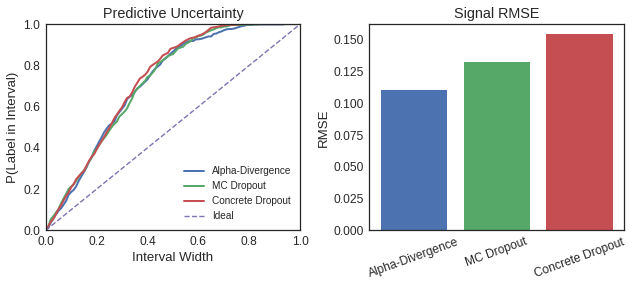

In [8]:
p_range = np.arange(0.0, 1.0, 0.01)
fig, axs = plt.subplots(1,2,figsize=(9,4))
axs = np.ravel(axs)

for i, (key, val) in enumerate(test_results.iteritems()):
    print key
    ratios = []
    std = val['std']
    mean = val['mu']
    for p_interval in p_range:
        p = 0.5 + p_interval/2.
        
        plow = (1. - p)/2
        phi = 1-plow
        samples = val['samples']
        low  = np.percentile(samples[:,:,0], plow*100,  axis=0)
        high = np.percentile(samples[:,:,0], phi*100, axis=0)
        
        z = scipy.stats.norm.ppf(p)
        low = mean - z*std
        high = mean + z*std
        obs_in_range = (Y_test[:,0] > low) * (Y_test[:,0] < high)
        
        
        #plt.hist(obs_in_range.mean(0))
        ratios.append(np.mean(obs_in_range))
    rmse = np.sqrt(np.mean((Y_signal[:,0] - mean)**2))
    axs[1].bar(i,rmse)
    axs[0].plot(p_range, ratios, label=key, lw=2)

axs[0].plot([0,1], [0,1], ls='dashed', label='Ideal')
axs[0].set_xlim([0.0,1])
axs[0].set_ylim([0,1])
axs[0].set_xlabel("Interval Width")
axs[0].set_ylabel("P(Label in Interval)")
axs[0].set_title("Predictive Uncertainty")
axs[0].legend(fontsize=10)

axs[1].set_title("Signal RMSE")
#axs[1].set_xlabel("Model")
axs[1].set_ylabel("RMSE")
#axs[1].set_xticklabels(test_results.keys(), rotation=30)
plt.tight_layout()
plt.xticks(range(3), test_results.keys(), axes=axs[1], rotation=20)

plt.savefig("figure2.pdf", pad_inches=5.0)
plt.show()


# Climate Downscaling Experiments - This is not completed

## Read Data

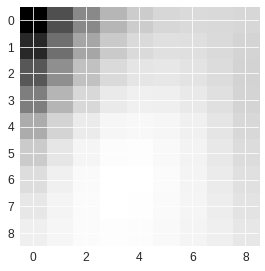

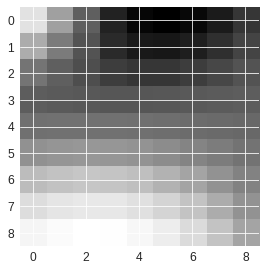

(8766, 9, 9, 1) (8766, 1)


In [7]:
import pandas as pd

Kmc = 30

def read_file(f):
    data = pd.read_csv(f, header=None)
    data = data.rename(columns={0: 'time', 1: 'label'})
    for c in data.columns:
        if isinstance(c, int) and ((c % 2) == 1):
            del data[c]
    X = data.values[:,2:]
    X = X.reshape((X.shape[0], 9, 9))[:,:,:,np.newaxis]
    plt.imshow(X[0,:,:,0], interpolation='nearest')
    plt.show()
    y = data.values[:,1,np.newaxis]
    return X, y

train_file = 'data/train_28.5384_-81.3792'
test_file = 'data/test_28.5384_-81.3792'

X_train, Y_train = read_file(train_file)
X_test, Y_test = read_file(test_file)
print X_train.shape, Y_train.shape

## Fit Concrete Dropout

$P(X=x) = P(X>0) P(X | X>0) + P(X=0)$  
$P(X=x) = P(X>0) P(X | X>0) $

In [8]:
from keras.layers import Conv2D, MaxPooling2D, Flatten
from sklearn.preprocessing import StandardScaler 

def fit_mc(nb_epoch, X, Y, output_activation=None, verbose=0,
           alpha_divergence=True, alpha=0.5, dropout_prob=0.5):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    D = np.prod(X.shape[1:])
    inp = Input(shape=X.shape[1:])
    x = inp
    #default_dropout_rate = 0.1
    for h in n_hidden:
        x = KerasMCDropout(Dense(h, activation='relu'), dropout_prob=dropout_prob)(x)
        
    mean = KerasMCDropout(Dense(1, activation=output_activation), dropout_prob=dropout_prob)(x)
    log_var = KerasMCDropout(Dense(1), dropout_prob=default_dropout_rate)(x)
    out = merge([mean, log_var], mode='concat')
    model = Model(inp, out)
    
    def alpha_divergence_loss(true, pred):
        # heteroskedastic case
        mean = pred[:,:1]
        log_var = pred[:,1:]
        precision = K.exp(-log_var)
        ll = K.sum(precision * (true - mean)**2. + log_var, axis=0)
        l = -1/alpha*K.log(K.sum(K.exp(-alpha*ll)))

        # homoskedastic case
        #l = -1/alpha*K.log(K.sum(K.exp(-alpha*tau/2.*K.sum((true - mean)**2, axis=0))))
        #l += N * D / 2. * K.log(tau)
        return l
       # return K.sum(precision * (true - pred)**2. + log_var, -1)
    
    def heteroskedastic_loss(true, pred):
        mean = pred[:,:1]
        log_var = pred[:,1:]
        precision = K.exp(-log_var)
        return K.sum(precision * (true - mean)**2. + log_var)
        
    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    if alpha_divergence:
        model.compile(optimizer=adam, loss=alpha_divergence_loss)
    else:
        model.compile(optimizer=adam, loss=heteroskedastic_loss)
        
    hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    loss = hist.history['loss']
    return model, loss  # return ELBO up to const.


def fit_concrete_climate(nb_epoch, X, Y, output_activation=None, verbose=0,
                        layer_sizes=[128,128], distribution='normal', 
                        learning_rate=1e-4):

    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = lr**2. / N
    dd = 2. / N
    inp = Input(shape=X.shape[1:])
    x = inp
    for h in layer_sizes:
        x = ConcreteDropout(Conv2D(h, (3,3), padding='valid', activation='relu'), 
                            weight_regularizer=wd, 
                            dropout_regularizer=dd)(x)
    #x = K.reshape(x, (-1, 9*9))
    x = Flatten()(x)

    mean = ConcreteDropout(Dense(1, activation=output_activation), 
                           weight_regularizer=wd, dropout_regularizer=dd)(x)
    log_var = ConcreteDropout(Dense(1), weight_regularizer=wd, dropout_regularizer=dd)(x)
    out = merge([mean, log_var], mode='concat')
    model = Model(inp, out)
    
    def normal_loss(true, pred):
        mean = pred[:, :1]
        log_var = pred[:, 1:]         ## log(sigma**2)
        precision = K.exp(-log_var)   ## 1/sigma**2
        return K.sum(precision * (true - mean)**2. + log_var, -1) 

    def lognormal_loss(true, pred):
        mean = pred[:, :1]
        log_var = pred[:, 1:]         ## log(sigma**2)
        precision = K.exp(-log_var)   ## 1/sigma**2
        return K.sum(precision * (tf.log(true) - mean)**2. + log_var, -1)  ## log(x) for the log distribution
    
    def gamma_loss(true, pred):
        alpha = K.exp(pred[:, :1])
        beta = K.exp(pred[:, 1:])
        return -(alpha - 1) * K.sum(K.log(true)) + beta * K.sum(true)
    
    def gumbel_loss(true, pred):
        mu = pred[:,:1]
        beta = K.exp(pred[:,1:])
        l = K.sum((true - mu) / beta) + batch_size * K.log(beta)
        l += K.sum(K.exp(-(true - mu)/beta))
        return l
    
    if distribution == 'normal':
        loss = normal_loss
    elif distribution == 'lognormal':
        loss = lognormal_loss
    elif distribution == 'gumbel':
        loss = gumbel_loss
    else:
        raise ValueError("I don't understand the distribution you requested.")
        
    adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, 
                           epsilon=1e-08, decay=0.0)
    model.compile(loss=loss, optimizer=adam)

    hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    Y_est = model.predict(X)
    hist_loss = hist.history['loss']
    return model, hist_loss  # return ELBO up to const.

def normal_moments(samples):
    """
    Prior distribution is log-normal
    E[X] = exp(mu + sigma**2/2)
    Var[X] = (exp(sigma**2) - 1) exp(2*mu + sigma**2)
    """
    mu = samples[:,0].mean(axis=1)
    second_moment = np.zeros(samples.shape[0])
    for k in range(samples.shape[2]):
        sample_var = np.exp(samples[:,1,k])
        sample_mean = samples[:,0,k]
        second_moment += sample_var + mu**2
    
    sigma2 = second_moment / samples.shape[2] - mu**2
    #Y_mean = np.exp(mu + sigma2 / 2.)
    #Y_var = (np.exp(sigma2) - 1) * np.exp(2*mu + sigma2)
    return mu, sigma2

def gumbel_moments(samples):
    '''
    E[X] = mu + beta * 0.5772
    Var[X] = pi**2 beta**2 / 6
    '''
    alpha_mean = samples[:,0].mean(axis=1)
    beta_mean = np.exp(samples[:,1]).mean(axis=1)
    return alpha_mean, beta_mean


In [ ]:
eps = 1e-2
distribution = 'gumbel'

train_rainy_days = X_train.mean(axis=3).mean(axis=2).mean(axis=1) > -0.1
test_rainy_days = X_test.mean(axis=3).mean(axis=2).mean(axis=1) > -0.1

x_mu = np.mean(X_train[train_rainy_days])
x_std = np.std(X_train[train_rainy_days])
X_train_norm = (X_train - x_mu) / x_std
X_test_norm = (X_test - x_mu) / x_std

Y_train[train_rainy_days] += eps
Y_test[test_rainy_days] += eps

#scale_y = StandardScaler().fit(Y_train[train_rainy_days])
#Y_train_norm = scale_y.transform(Y_train)

model, loss = fit_concrete_climate(25, X_train_norm[train_rainy_days], Y_train[train_rainy_days], 
                output_activation=None, verbose=1, layer_sizes=[128,128,], 
                distribution=distribution)

Y_samples = np.zeros(shape=(X_test.shape[0], 2, Kmc))
Y_samples[test_rainy_days] = np.array([model.predict(X_test_norm[test_rainy_days]) for _ in range(Kmc)]).swapaxes(0,1).swapaxes(1,2)
#Y_samples[test_rainy_days] = np.array([scale_y.inverse_transform(model.predict(X_test_norm[test_rainy_days])) 
#                                       for _ in range(Kmc)]).swapaxes(0,1).swapaxes(1,2)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Epoch 1/25
8566/8566 [==============================] - 4s - loss: 26.6430     
Epoch 2/25
8566/8566 [==============================] - 3s - loss: 18.9031     
Epoch 3/25
8566/8566 [==============================] - 3s - loss: 17.0914     
Epoch 4/25
8566/8566 [==============================] - 3s - loss: 16.4739     
Epoch 5/25
8566/8566 [==============================] - 3s - loss: 14.3414     
Epoch 6/25
8566/8566 [==============================] - 3s - loss: 14.4813     
Epoch 7/25
8566/8566 [==============================] - 3s - loss: 13.2532     
Epoch 8/25
8566/8566 [==============================] - 3s - loss: 15.3702     
Epoch 9/25
8566/8566 [==============================] - 3s - loss: 12.8155     
Epoch 10/25
8566/8566 [==============================] - 3s - loss: 12.9435     
Epoch 11/25
8566/8566 [==============================] - 3s - loss: 12.4179     
Epoch 12/25
8566/8566 [==============================] - 3s - loss: 11.7516     
Epoch 13/25
8566/8566 [==============

In [ ]:
import seaborn as sns

if distribution == 'gumbel':
    alpha, beta = gumbel_moments(Y_samples[test_rainy_days])
    mu = alpha + beta * 0.5772
    sigma2 = np.pi**2 / 6. * beta**2
elif distribution == 'normal':
    mu, sigma2 = normal_moments(Y_samples[test_rainy_days])

rainy_test = Y_test[test_rainy_days, 0]

idxs = np.argsort(rainy_test)
lw=0.1
fig, axs = plt.subplots(3,3, figsize=(12,8))
axs = np.ravel(axs)
base = 5
for ax, i in zip(axs, idxs[::-1][base:base+len(axs)]):
    xr = np.arange(-50.,mu[i]*5.,0.1)
    if distribution == 'gumbel':
        dist = scipy.stats.gumbel_r(loc=alpha[i], 
                              scale=beta[i])
    elif distribution == 'normal':
        dist = scipy.stats.norm(loc=mu[i], 
                              scale=np.sqrt(sigma2[i]))
    ax.plot(xr, dist.pdf(xr),
            label='pdf', color='red')
    ax.axvline(rainy_test[i], ls='--', label='Observed\nPrecip')

    ax.legend()
    
plt.show()

In [ ]:
idx = np.argsort(mu)[-2]

m = mu[idx-5:idx+6]
s = np.sqrt(sigma2[idx-5:idx+6])
y_est = []

low, high = [], []
for i in range(len(m)):
    if distribution == 'normal':
        dist = scipy.stats.norm(loc=m[i], scale=np.sqrt(s[i]))
    elif distribution == 'gumbel':
        dist = scipy.stats.gumbel_r(loc=alpha[i], 
                        scale=beta[i])
    y_est += [dist.mean()]
    high += [dist.ppf(0.9)]
    low += [dist.ppf(0.1)]

label = Y_test[idx-5:idx+6]

plt.figure(figsize=(10,6))
plt.plot(y_est)
plt.plot(label, ls=':')
plt.plot(low, color='green', ls='--')
plt.plot(high, color='red', ls='--')


## How good is our coverage?

In [ ]:
cdf = []
#for i in np.where(test_rainy_days)[0]:
for i in np.where(rainy_test > 0.)[0]:
    if distribution == 'gumbel':
        dist = scipy.stats.gumbel_r(loc=alpha[i], scale=beta[i])
    elif distribution == 'normal':
        dist = scipy.stats.norm(loc=mu[i], scale=sigma2[i]**(0.5))
    cdf.append(dist.cdf(Y_test[i])[0])
    
plt.hist(cdf)
plt.xlabel("CDF")

In [ ]:
p_range = np.arange(0.0, 1.0, 0.01)
fig, axs = plt.subplots(1,1,figsize=(9,4))
axs = np.ravel(axs)

ratios = []
std = sigma2**2
mean = mu
for p_interval in p_range:
    p = 0.5 + p_interval/2.

    plow = (1. - p)/2
    phi = 1-plow
    
    ratios.append(np.mean((cdf > plow) * (cdf < phi)))

axs[0].plot(p_range, ratios)
axs[0].plot([0,1], [0,1], ls='--')
